In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/home/keithyamkf/jupyter-notebook/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [3]:
cpu_count()

16

### Begin

In [4]:
num_of_years = 1
start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
end = dt.date.today()

In [5]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/all_stock_close_cleaned.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0007.HK,0008.HK,0010.HK,0011.HK,...,6868.HK,6869.HK,6878.HK,6881.HK,6886.HK,6889.HK,6890.HK,6893.HK,6896.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,66.068962,75.704773,13.765183,17.992689,57.830746,52.005646,0.84,4.296173,18.745403,149.965576,...,5.792519,13.036684,0.43,4.043017,12.284131,9.617226,1.0494,0.65,1.102041,197.600006
2019-12-12,67.205635,76.889137,13.857778,18.326250,58.378670,52.524284,0.84,4.324192,18.823429,151.492905,...,5.782881,13.485552,0.44,4.023580,12.225635,9.617226,1.0494,0.62,1.102041,200.199997


In [6]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)

### Fina the NaN in comb_df

In [9]:
comb_df.dropna(axis=0, how='any', inplace=True)

In [10]:
comb_df.tail(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,6868.HK,6869.HK,6878.HK,6881.HK,6886.HK,6889.HK,6890.HK,6893.HK,6896.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-16,-0.023898,-0.004952,-0.017212,0.000000,-0.008500,-0.009828,0.009569,-0.002077,-0.008351,0.003646,...,0.006814,0.037023,0.000000,0.006543,0.000000,-0.011187,-0.012903,-0.058269,0.007067,0.020121
2020-12-17,0.008337,0.005658,0.000000,0.005147,0.007290,0.008605,0.000000,-0.008351,0.005227,-0.000728,...,-0.001699,0.011719,0.013423,0.012959,0.003478,-0.007528,0.012903,0.039221,0.000000,0.027507
2020-12-18,-0.001847,-0.005658,0.000000,-0.001027,0.009639,-0.007371,0.009479,0.004184,0.010373,-0.004380,...,0.000000,0.011583,-0.013423,-0.019502,0.018917,0.000000,0.012739,0.091808,-0.014185,-0.009346


In [11]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [ ]:
prev_col = [x for x in comb_df.columns.to_list() if '.prev' in x]

In [ ]:
comb_df[prev_col].dropna(axis=0, how='all')

In [ ]:
comb_df.loc['2019-12-23', prev_col]

In [ ]:
comb_df.isnull().values.any()

In [ ]:
comb_df.dropna(axis=0, how='all', inplace=True)

In [ ]:
comb_df.head(3)

In [ ]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [ ]:
comb_df.tail(3)

In [12]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    return data

### Compare linear regression for 2 selected stocks

In [ ]:
prev_stock = '6190.HK.prev'
today_stock = '0247.HK'
prevday_returns[prev_stock]
today_returns[today_stock]

In [ ]:
prevday_returns

### Non parallel processing

In [ ]:
%%time
catstocks = new_col
catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
results = [get_linear_regression(pair, prevday_returns, today_returns) for pair in pair_list]
result_df = pd.DataFrame(results)
result_df

### Parrallel processing

In [13]:
%%time
catstocks = new_col
# catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
cpu = cpu_count()
print('cpu count = {}'.format(cpu))
executor = Parallel(n_jobs=cpu, backend='multiprocessing')
tasks = (delayed(get_linear_regression)(pair, prevday_returns, today_returns) for pair in pair_list)
results = executor(tasks)
result_df = pd.DataFrame(results)
result_df

cpu count = 16


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwar

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return

CPU times: user 6min 51s, sys: 18.5 s, total: 7min 10s
Wall time: 1h 6min 41s


,Prev,Today,Params,TValues,RSquared
0,0001.HK.prev,0002.HK,0.001164,0.029256,0.000003
1,0001.HK.prev,0003.HK,-0.023111,0.502208,0.001012
2,0001.HK.prev,0004.HK,0.068773,0.921010,0.003395
3,0001.HK.prev,0005.HK,0.016084,0.244368,0.000240
4,0001.HK.prev,0006.HK,0.071583,1.612042,0.010329
...,...,...,...,...,...
1484737,9988.HK.prev,6886.HK,-0.008726,0.138780,0.000077
1484738,9988.HK.prev,6889.HK,-0.041787,0.808911,0.002621
1484739,9988.HK.prev,6890.HK,0.095069,1.130569,0.005107
1484740,9988.HK.prev,6893.HK,0.004852,0.089211,0.000032


In [14]:
result_df.to_csv('../data/regression_pair.csv')

### Read Regression Result

In [15]:
result_df = pd.read_csv('../data/regression_pair.csv', index_col=0)

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
1290422,2892.HK.prev,1121.HK,-5.219080,18.076209,0.567520
1381273,3878.HK.prev,0100.HK,-0.159838,14.546648,0.459407
651576,1076.HK.prev,6093.HK,-0.475328,13.661497,0.428423
75235,0100.HK.prev,2139.HK,-0.927158,12.433568,0.383043
430011,0676.HK.prev,0096.HK,0.501969,12.354395,0.380028
1184176,2300.HK.prev,0521.HK,-0.536902,11.931640,0.363764
749147,1243.HK.prev,0127.HK,-0.294825,11.642801,0.352498
618085,1004.HK.prev,1121.HK,0.859708,11.193954,0.334766
1112568,2014.HK.prev,1076.HK,-0.486338,11.140537,0.332639
204071,0281.HK.prev,1358.HK,2.618079,11.116956,0.331699


### Analyze the Top pair

2892.HK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total prev stock rise 24
Total prev stock rise and today rise 3


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


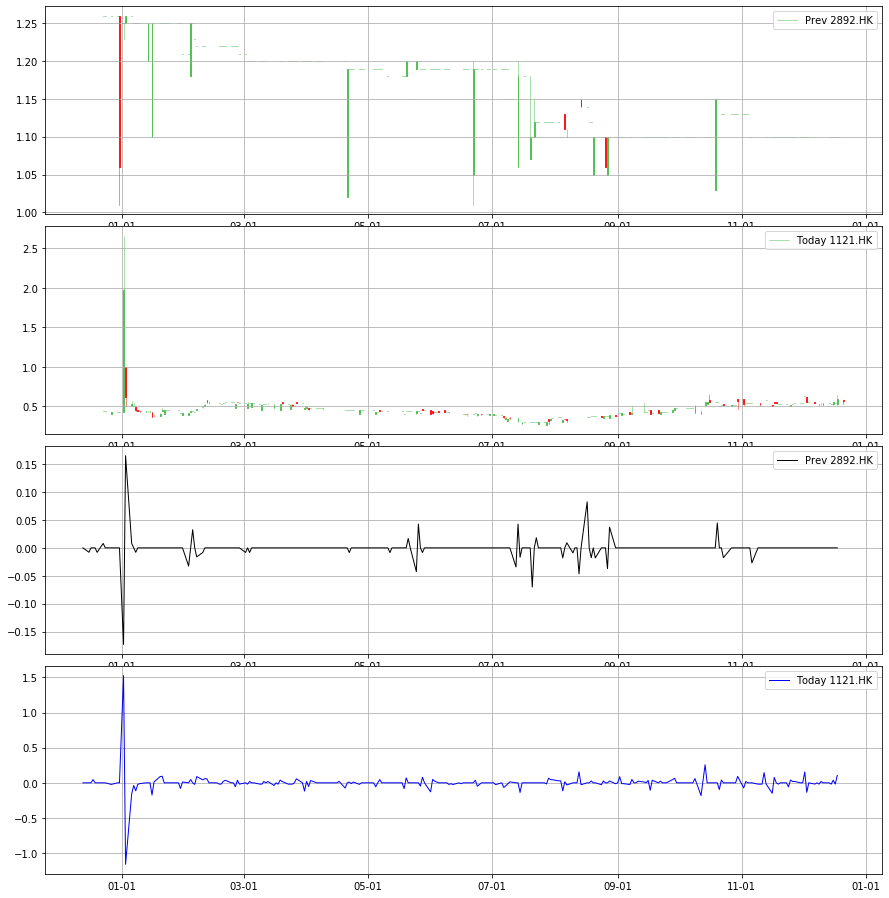

In [17]:
stock1 = '2892.HK.prev'
stock2 = '1121.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, start)

### Upload to AWS S3

In [23]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.upload_data_to_s3(s3_bucket, local_path)

### Verify Linear regression

    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }

In [19]:
prevday_returns[stock1]

Date
2019-12-13    0.000000
2019-12-16   -0.007905
2019-12-17    0.000000
2019-12-18    0.000000
2019-12-19    0.000000
                ...   
2020-12-14    0.000000
2020-12-15    0.000000
2020-12-16    0.000000
2020-12-17    0.000000
2020-12-18    0.000000
Name: 2892.HK.prev, Length: 251, dtype: float64

In [20]:
today_returns[stock2]

Date
2019-12-13    0.000000
2019-12-16    0.000000
2019-12-17    0.000000
2019-12-18    0.046520
2019-12-19    0.000000
                ...   
2020-12-14    0.000000
2020-12-15   -0.018692
2020-12-16    0.037041
2020-12-17   -0.018349
2020-12-18    0.105361
Name: 1121.HK, Length: 251, dtype: float64

In [22]:
X = prevday_returns[stock1].copy()
X = sm.add_constant(X)
y = today_returns[stock2]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

Params -5.2191 TValues -18.0762 RSquared 0.5675
